# Stability Analysis & Variational Bayesian Gaussian Mixture

In this notebook, the stability of the Callaham proposed method is tested, by comparing the results obtained when setting multiple number of clusters when initialising the model.

First, the same preprocessing is done, as in the ```Boundary_Layer``` Notebook.

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs
import stability_assessment as sa


import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
%config InlineBackend.figure_format = 'retina'


from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns

sns_list = sns.color_palette("deep").as_hex()
sns_list.insert(0, "#ffffff")
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# 1. Preprocessing

## a. Load the data

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

In [4]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [5]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

Dy = sparse.diags([-1, 1], [-1, 1], shape=(ny, ny)).toarray()

# Get 2nd order forward/backwards at the boundaries
Dy[0, :3] = np.array([-3, 4, -1])
Dy[-1, -3:] = np.array([1, -4, 3])

for i in range(ny - 1):
    Dy[i, :] = Dy[i, :] / (2 * dy[i])
Dy[-1, :] = Dy[-1, :] / (2 * dy[-1])

# Repeat this for the x-direction
Dy = sparse.block_diag([Dy for i in range(nx)])  # Creates a block diagonal matrix
# with the Dy matrix on the diagonal

Dx = sparse.diags([-1, 1], [-ny, ny], shape=(nx * ny, nx * ny))
Dx = sparse.lil_matrix(Dx)

# Get 2nd order forwards/backwards with boundary conditions
for i in range(ny):
    Dx[i, i] = -3
    Dx[i, ny + i] = 4
    Dx[i, 2 * ny + i] = -1
    Dx[-(i + 1), -(i + 1)] = 3
    Dx[-(i + 1), -(ny + i + 1)] = -4
    Dx[-(i + 1), -(2 * ny + i + 1)] = 1
Dx = Dx / (2 * dx)

Dx = sparse.csr_matrix(Dx)
Dy = sparse.csr_matrix(Dy)

Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [6]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## c. Equation space representation

In [7]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [8]:
# Get terms stored as features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# 2. Stability Assessment


## A. Under different number of clusters set

Again, a standard K-Means algorithm is used here, with setting the number of clusters to 6.

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


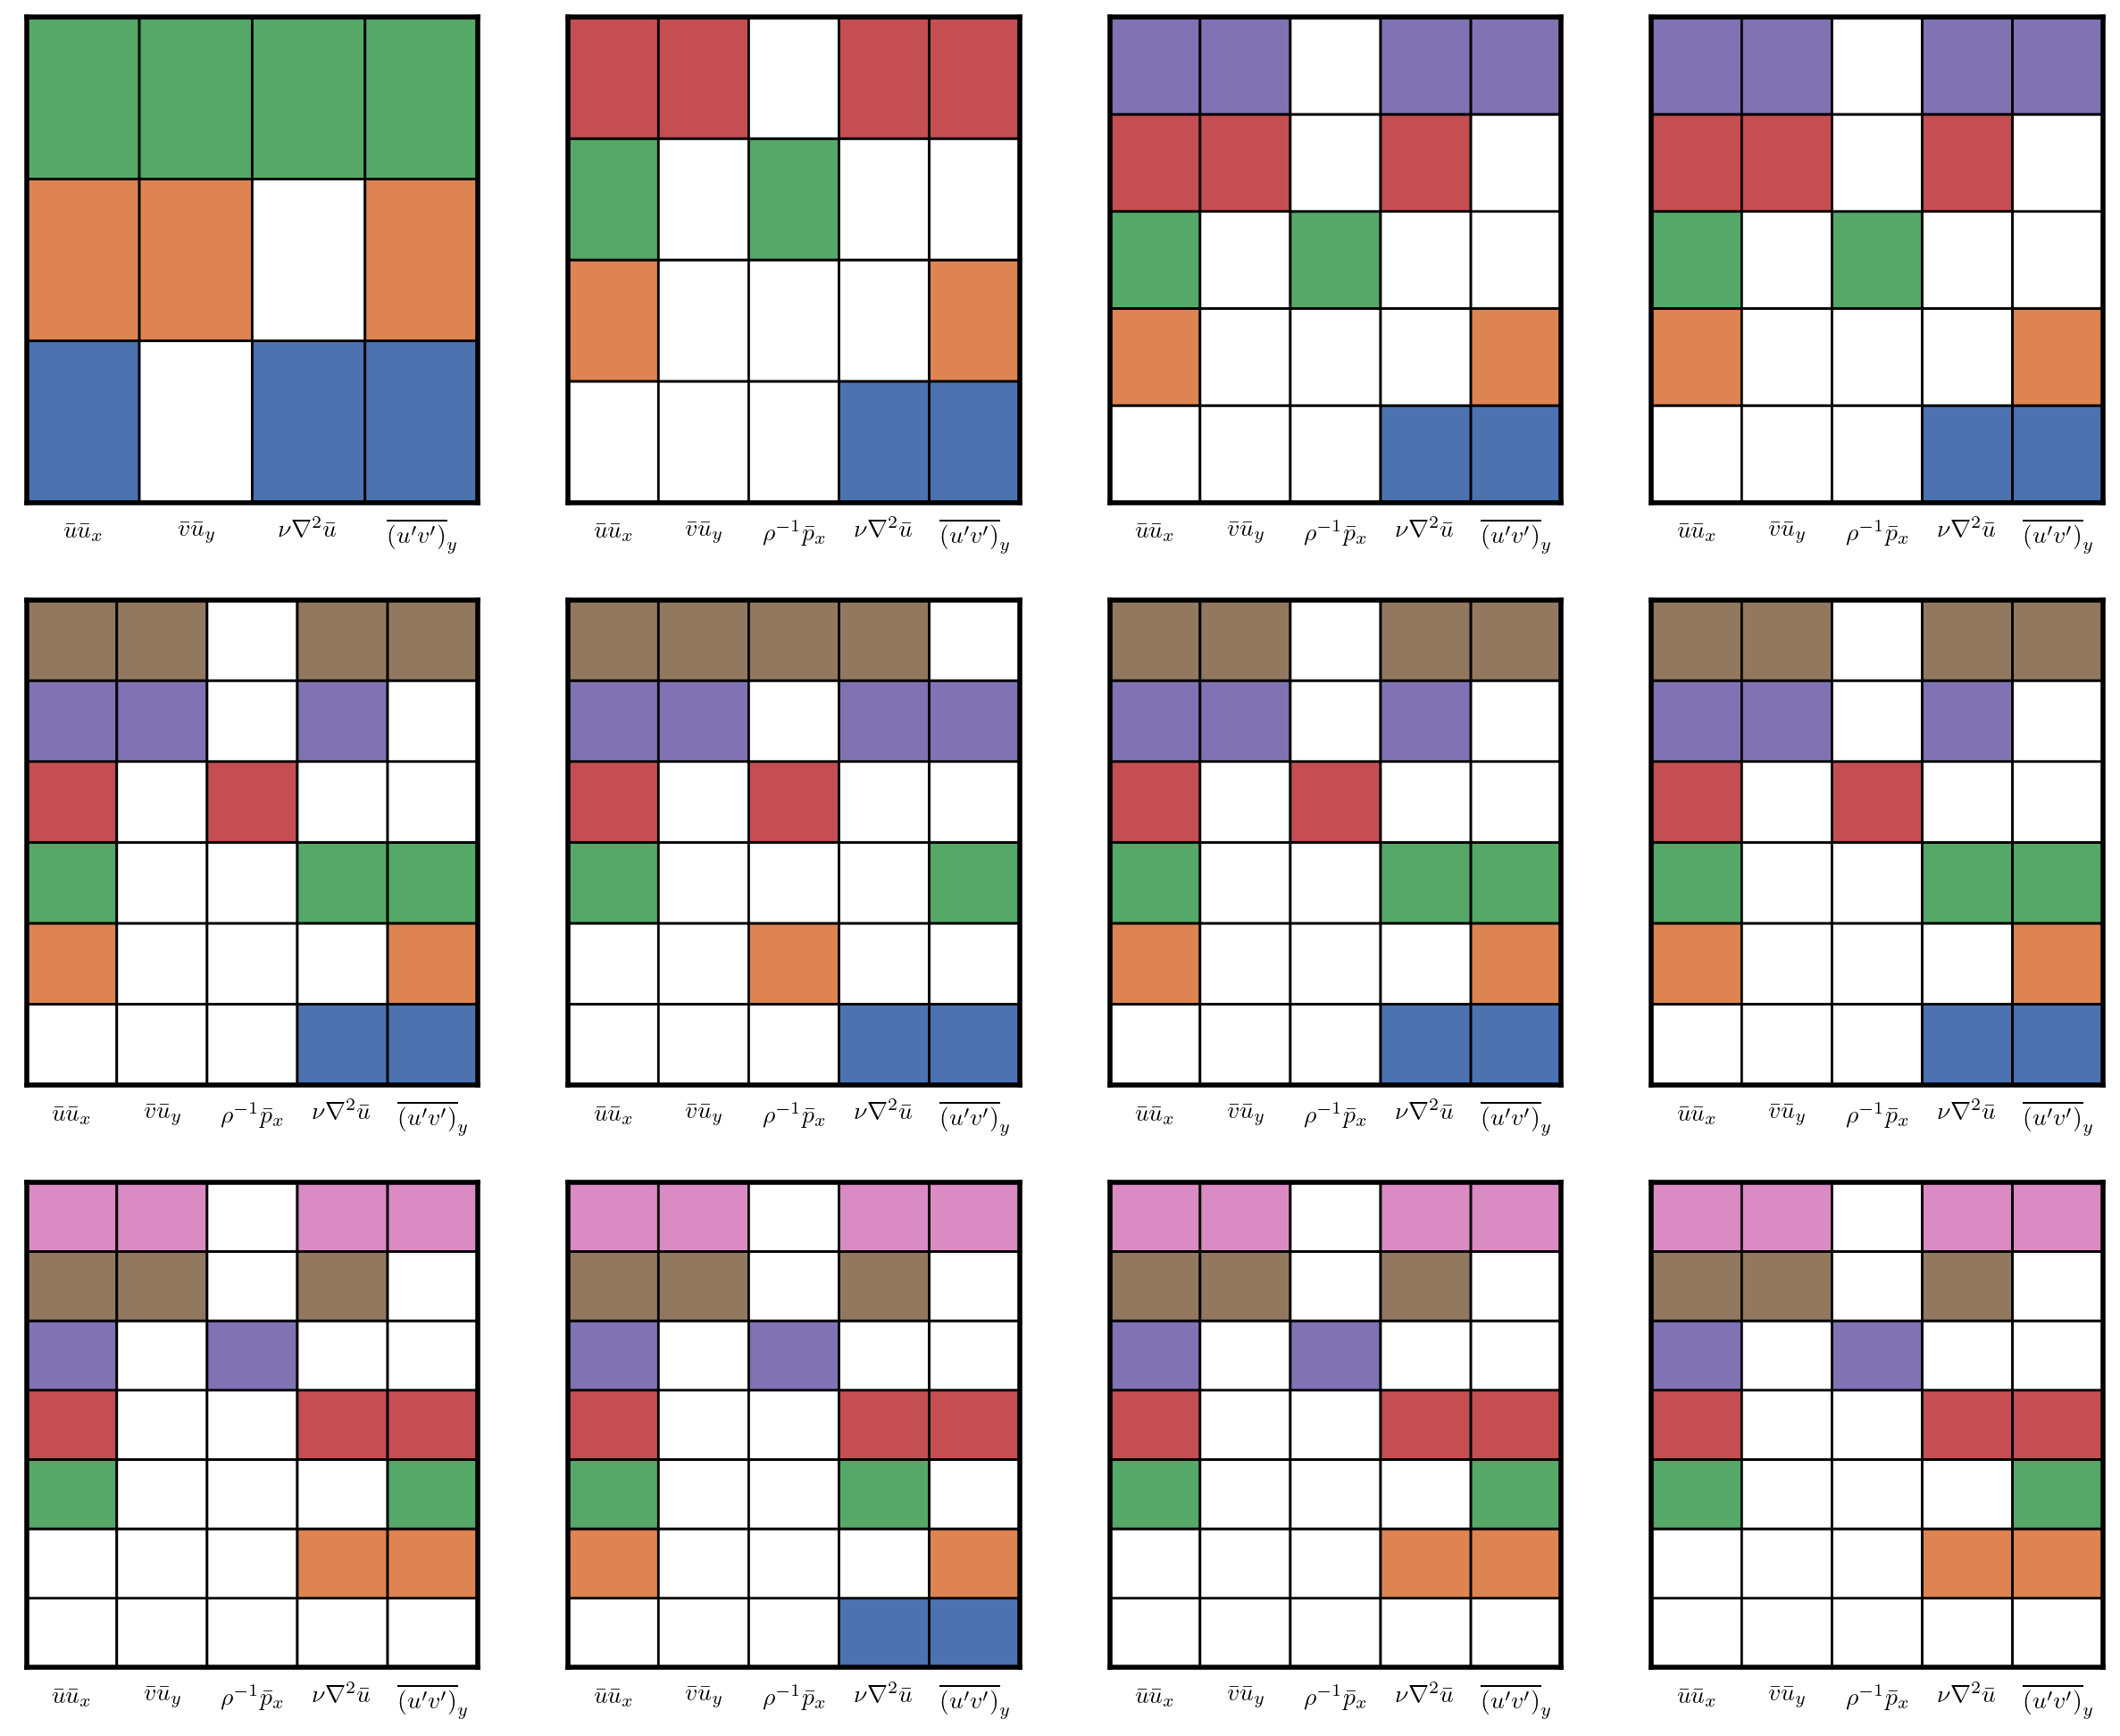

Text(0, 0.5, 'Number of unique balance models found')

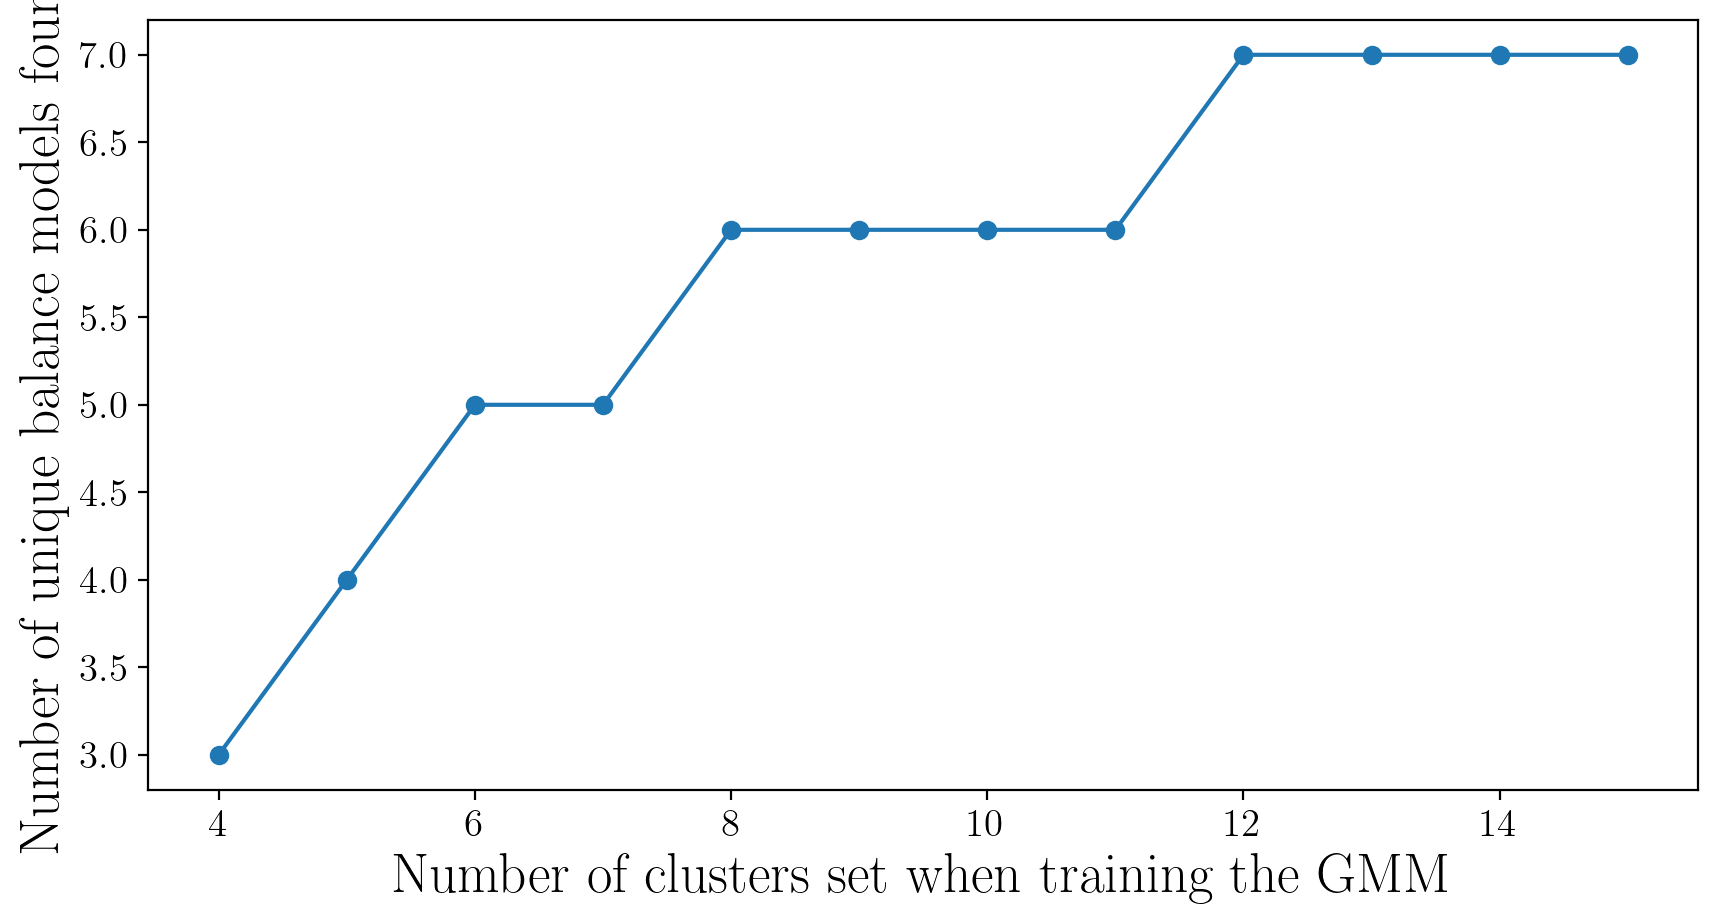

In [9]:
# Initialise a list of the number of dominant balance models found
nmodels_list = []

# Define a list of number of clusters to set
n_clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
np.random.seed(75016)

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(15, 12))
for n_cluster in n_clusters:
    # Get clusters for the current number of clusters
    cluster_idx = sa.get_clusters(n_cluster, features, 0.1)

    alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
    spca_model = sa.get_spca_active_terms(
        alpha_opt, n_cluster, cluster_idx, features, nfeatures
    )

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 4, n_cluster - 3)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_clusters, nmodels_list, "o-")
plt.xlabel("Number of clusters set when training the GMM")
plt.ylabel("Number of unique balance models found")

In [10]:
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

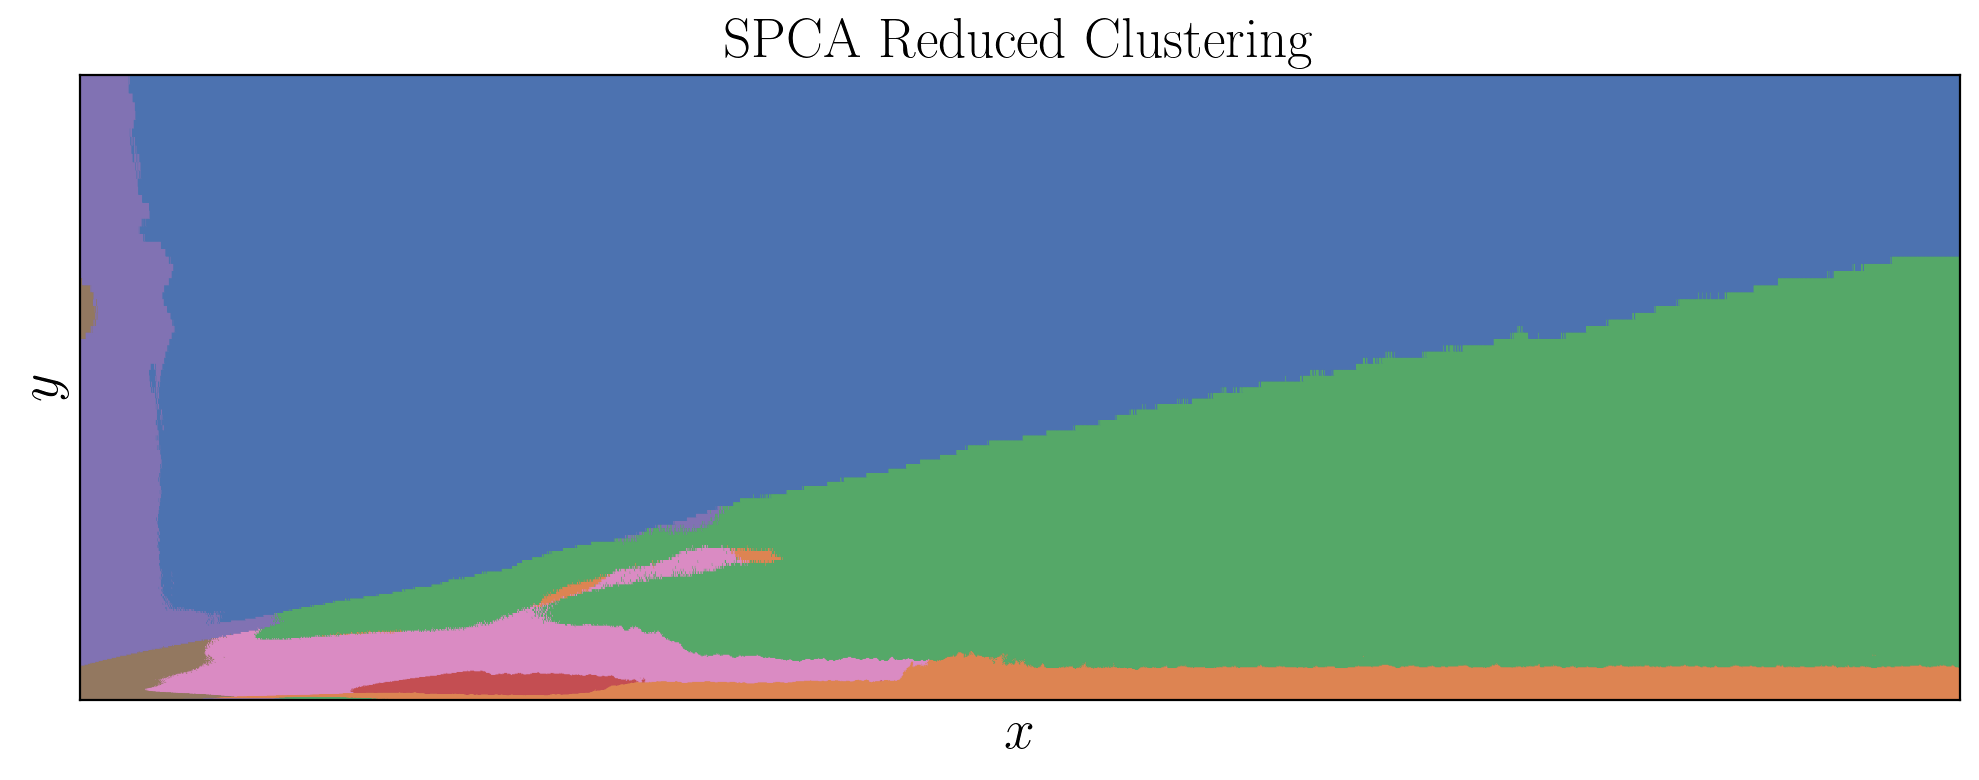

In [11]:
pf.plot_spca_reduced_clustering(x, y, balancemap)

## B. Under different training set sizes

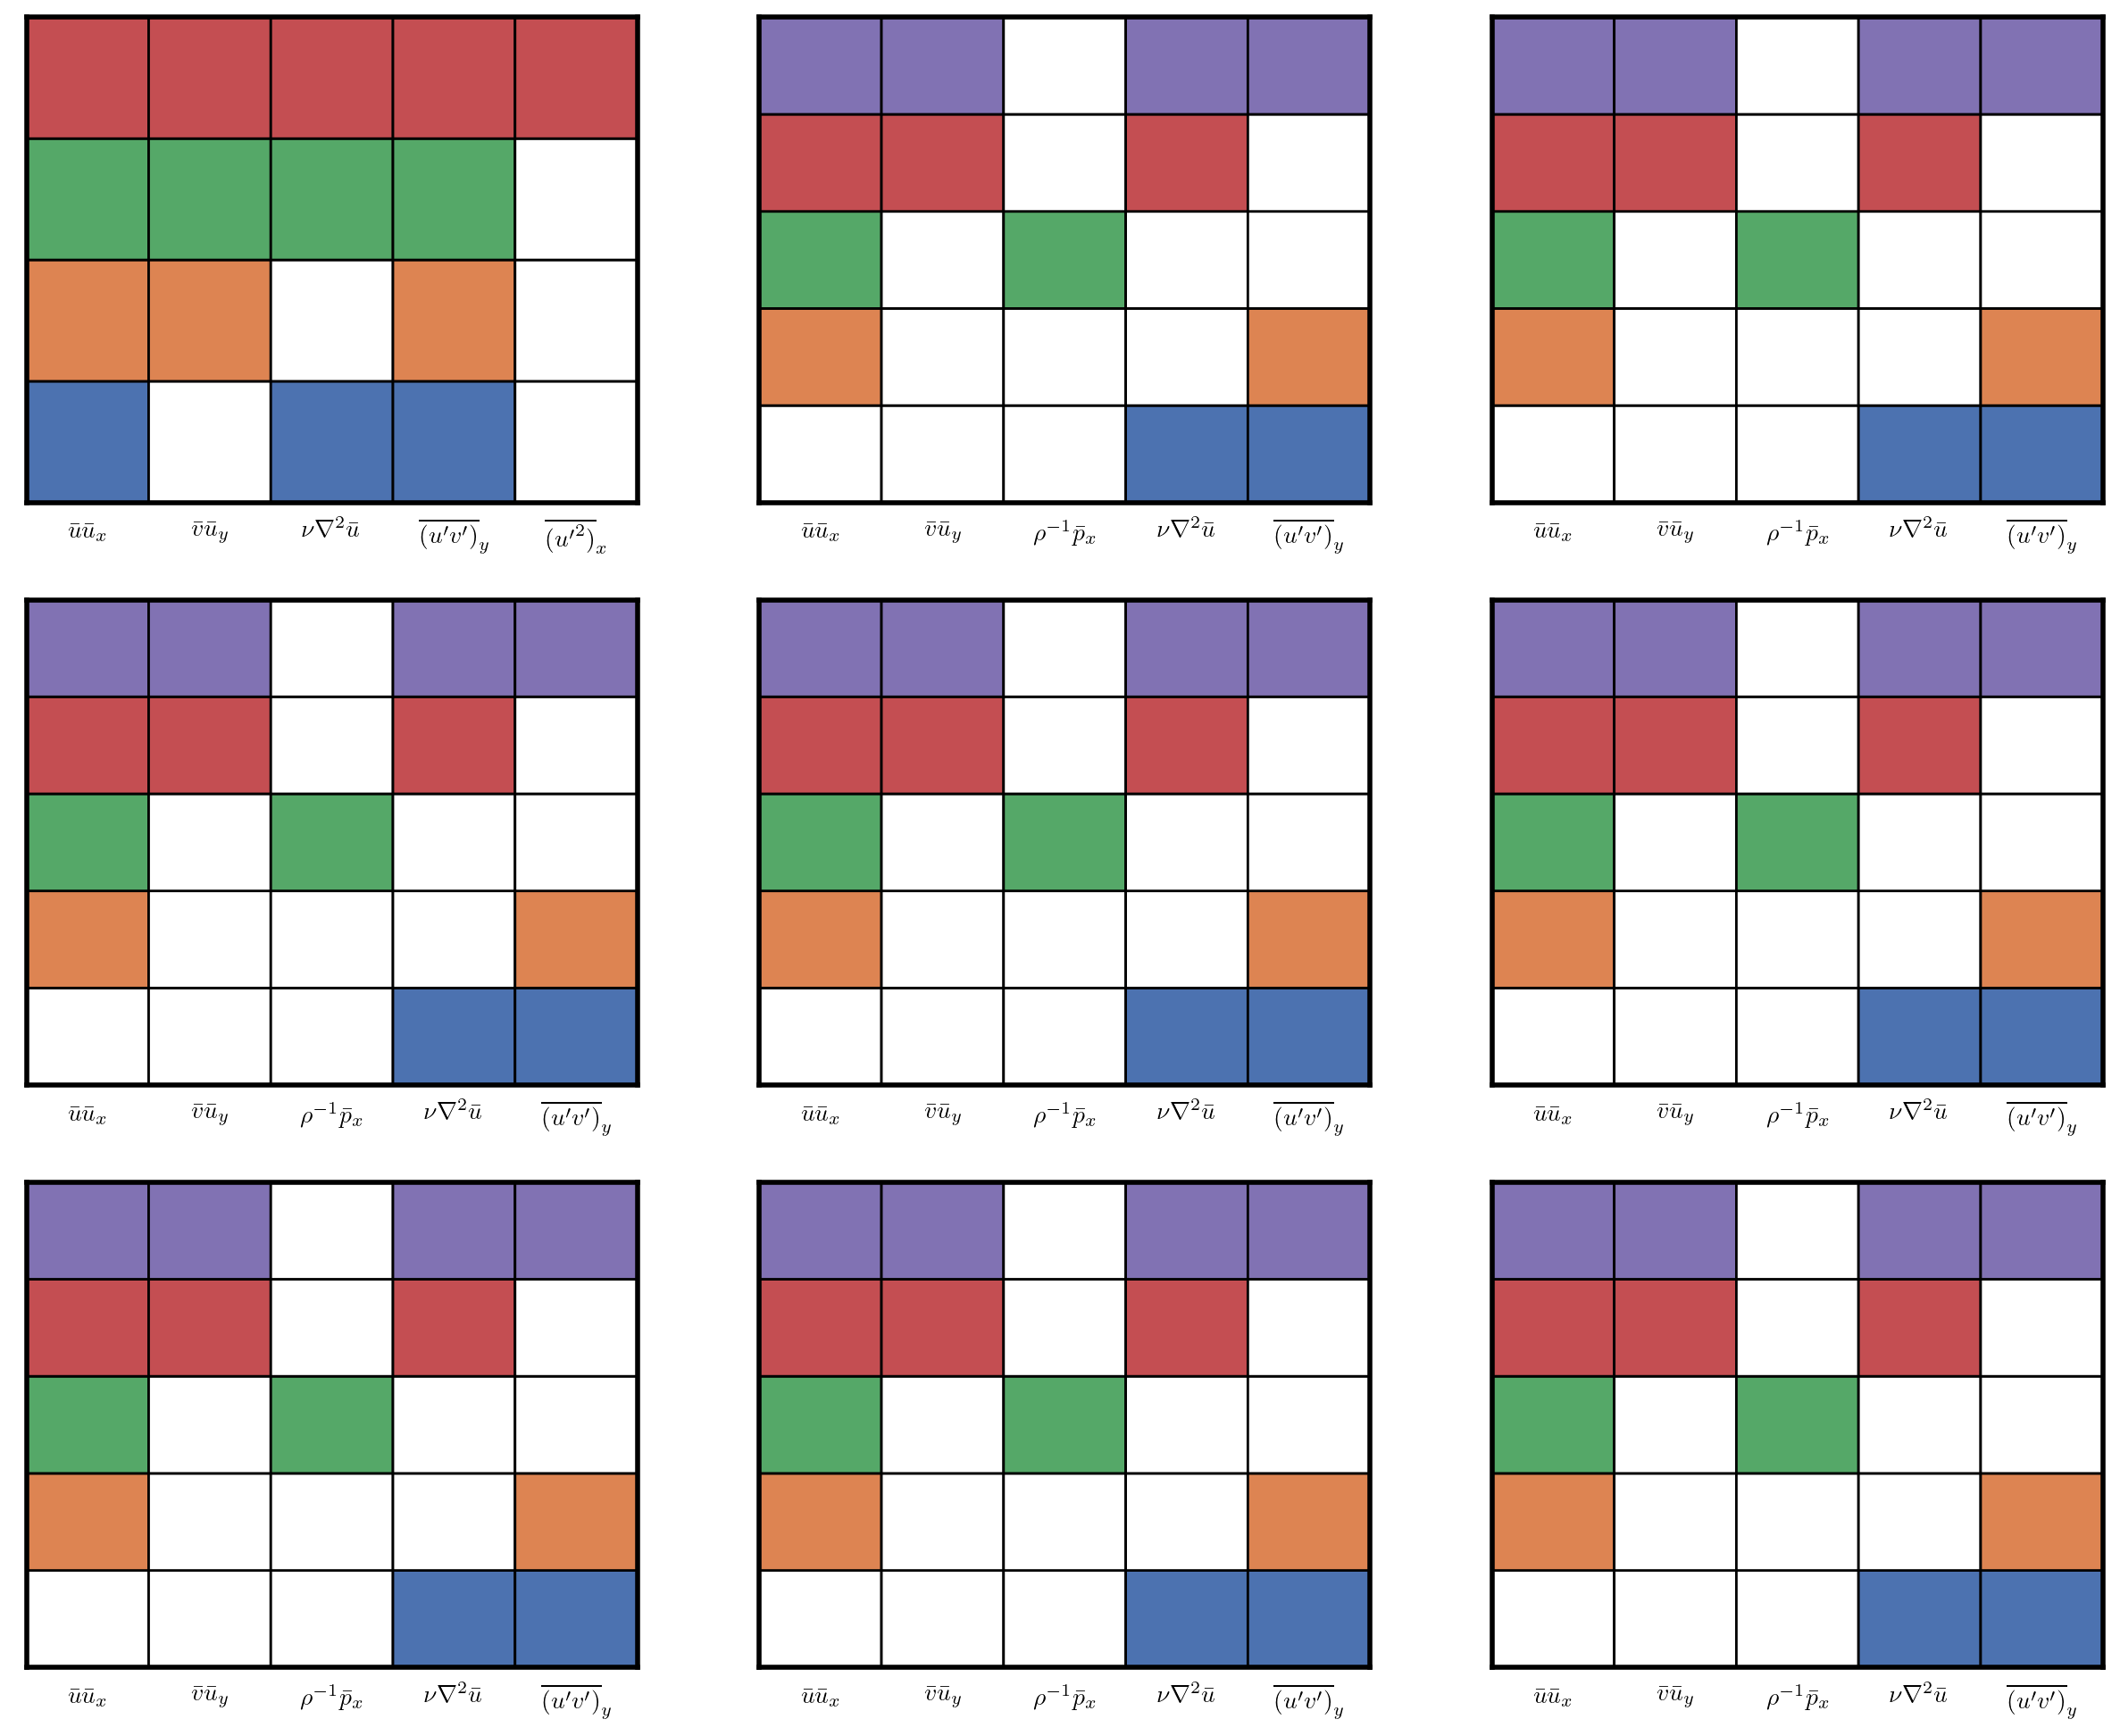

In [12]:
# Define a list of training set sizes, as fractions of the total dataset
train_frac = [0.01, 0.02, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 0.9]

# Plot all found dominant balance regimes for each initial cluster number
plt.figure(figsize=(15, 12))
for idx, frac in enumerate(train_frac):
    # Get clusters for the current number of clusters
    cluster_idx = sa.get_clusters(n_clusters=6, features=features, train_frac=frac)

    alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
    spca_model = sa.get_spca_active_terms(
        alpha_opt, 6, cluster_idx, features, nfeatures
    )

    (
        balance_models,
        model_index,
        nmodels,
        gridmap,
        grid_labels,
    ) = sa.get_unique_balance_models(spca_model)

    nmodels_list.append(nmodels)

    plt.subplot(3, 3, idx + 1)
    plt.pcolor(
        gridmap, vmin=-0.5, vmax=cm.N - 0.5, cmap=cm, edgecolors="k", linewidth=1
    )
    plt.gca().set_xticks(np.arange(0.5, len(grid_labels) + 0.5))
    plt.gca().set_xticklabels(grid_labels, fontsize=10)
    plt.gca().set_yticklabels([])

    for axis in ["top", "bottom", "left", "right"]:
        plt.gca().spines[axis].set_linewidth(2)

    plt.gca().tick_params(axis="both", width=0)

plt.show()

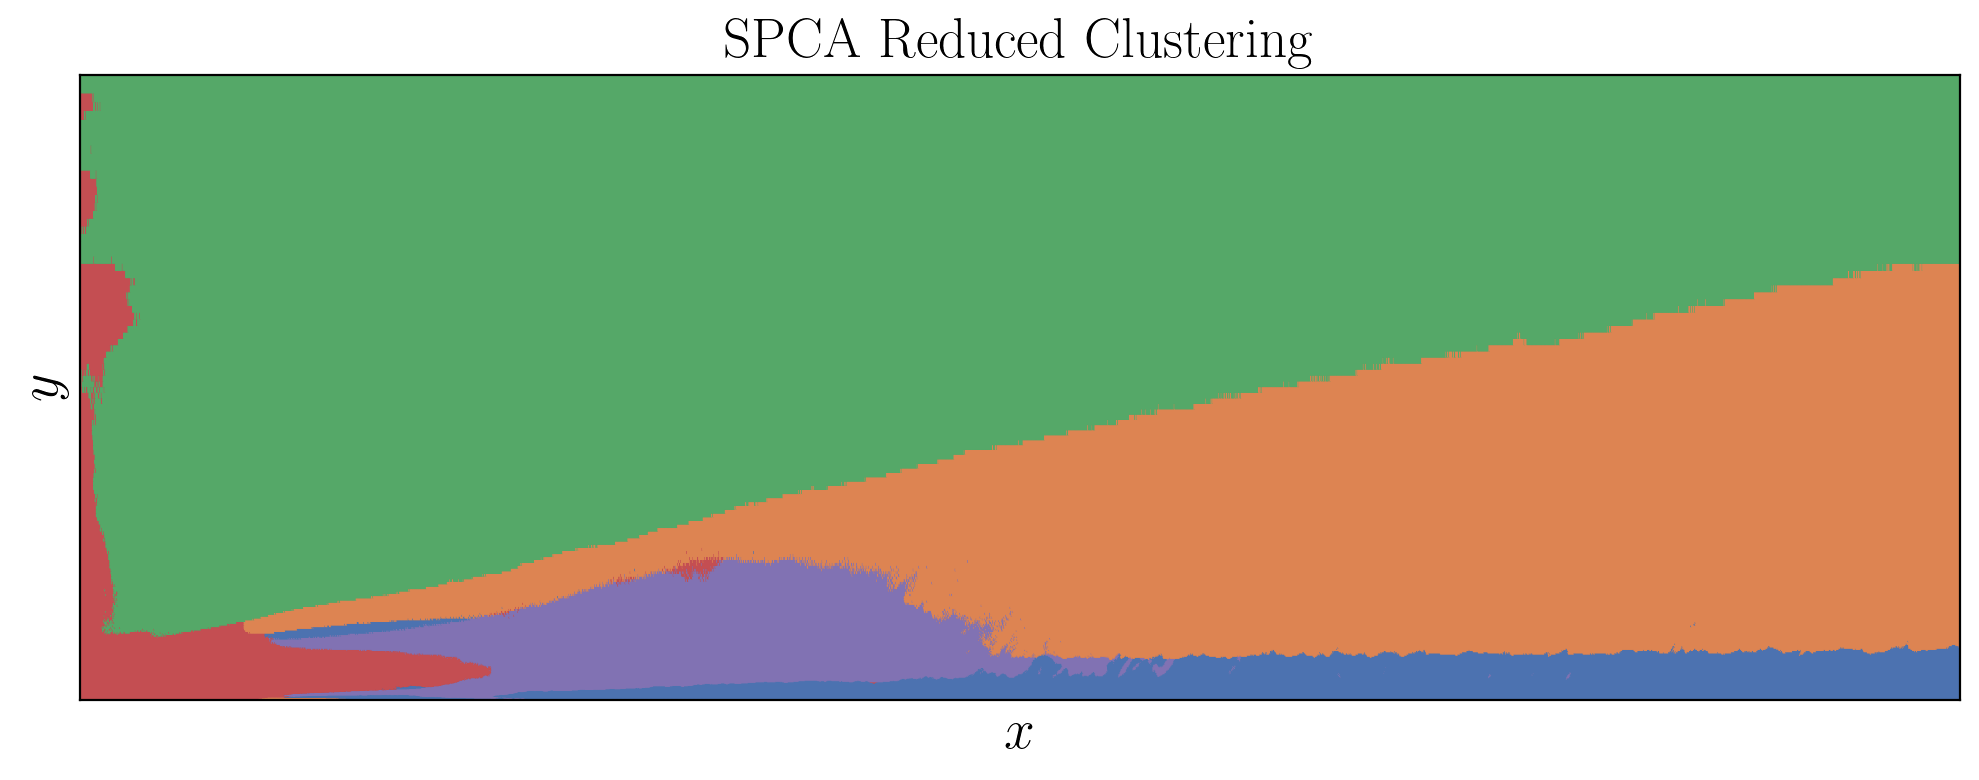

In [13]:
# Get clusters for training set size: 0.5
cluster_idx = sa.get_clusters(n_clusters=6, features=features, train_frac=0.9)

alpha_opt = 10  # Optimal alpha value, in all cases the optimal alpha is 10
spca_model = sa.get_spca_active_terms(alpha_opt, 6, cluster_idx, features, nfeatures)

(
    balance_models,
    model_index,
    nmodels,
    gridmap,
    grid_labels,
) = sa.get_unique_balance_models(spca_model)

balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

pf.plot_spca_reduced_clustering(x, y, balancemap)

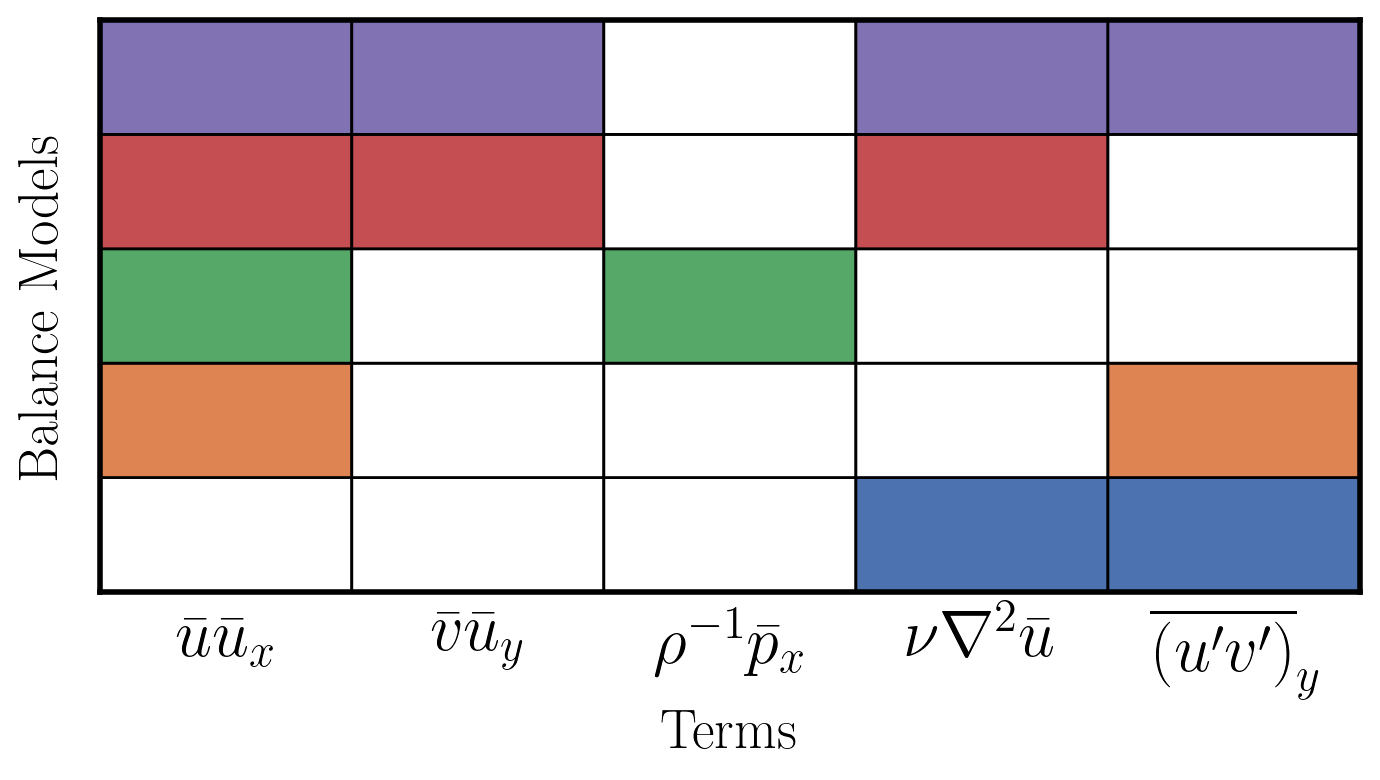

In [14]:
pf.plot_balance_models(gridmap, grid_labels)